In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, LSTM, Dense, Multiply, Lambda, Softmax, Concatenate, Embedding, Bidirectional)
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import MinMaxScaler
import tensorflow.keras.backend as K

# Load dataset
file_path = "data-big.csv"  # Replace with actual path
df = pd.read_csv(file_path)

# Shuffle dataset
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

# 🔻 FILTER OUT ZERO CONVERSION ROWS
#df = df[df['AllConversions'] > 0].reset_index(drop=True)

# Separate
df_positive = df[df['AllConversions'] > 0]
df_zero = df[df['AllConversions'] == 0]

# Sample 10% of zero rows (adjust as needed)
df_zero_sampled = df_zero.sample(frac=0.01, random_state=42)

# Combine and shuffle
df = pd.concat([df_positive, df_zero_sampled]).sample(frac=1, random_state=42).reset_index(drop=True)


df['Date'] = pd.to_datetime(df['Date'])
df['Day'] = df['Date'].dt.day
df['Month'] = df['Date'].dt.month
df['DayOfWeek'] = df['Date'].dt.dayofweek

#df['CTR'] = df['Interactions'] / df['Impressions'].replace(0, np.nan)
#df['CTR'] = df['CTR'].fillna(0)
df['CTR'] = df['CTR'].str.rstrip('%').astype(float) / 100


# Tokenize search terms
tokenizer = Tokenizer(filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(df['SearchTerm'])
vocab_size = len(tokenizer.word_index) + 1
search_term_sequences = tokenizer.texts_to_sequences(df['SearchTerm'])
max_seq_length = max(len(seq) for seq in search_term_sequences)
search_term_padded = pad_sequences(search_term_sequences, maxlen=max_seq_length, padding='post')

# Create embedding layer with simple tokenizer embedding
embedding_dim = 50  # Define embedding dimension
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, trainable=True)

# Scale numerical features
scaler = MinMaxScaler()
numerical_features = scaler.fit_transform(df[['Impressions', 'Interactions','CTR', 'Day', 'Month', 'DayOfWeek']])

X_search_term = np.array(search_term_padded)
X_numerical = numerical_features.reshape((numerical_features.shape[0], 6, 1))  # Time-step format
#df['AllConversions'] *= 10
y = np.array(df['AllConversions'])

# Define model
search_term_input = Input(shape=(max_seq_length,), name="search_term_input")
embedded_search_terms = embedding_layer(search_term_input)
lstm_out, state_h, state_c = LSTM(128, return_sequences=True, return_state=True)(embedded_search_terms)

# Attention for Search Terms
attention_scores = Dense(128, activation="tanh")(lstm_out)
attention_weights = Dense(1, activation="sigmoid")(attention_scores)
context_vector = Multiply()([lstm_out, attention_weights])
context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(context_vector)

# LSTM for Numerical Features with Attention
numerical_input = Input(shape=(6, 1), name="numerical_input")
numerical_lstm_out = LSTM(64, return_sequences=True)(numerical_input)
num_attention_scores = Dense(64, activation="tanh")(numerical_lstm_out)
num_attention_weights = Dense(1, activation="sigmoid")(num_attention_scores)
num_context_vector = Multiply()([numerical_lstm_out, num_attention_weights])
num_context_vector = Lambda(lambda x: tf.reduce_sum(x, axis=1))(num_context_vector)

# Merge features
merged = Concatenate()([context_vector, num_context_vector])
output = Dense(1, activation="linear")(merged)

# Compile Model
model = Model(inputs=[search_term_input, numerical_input], outputs=output)
model.compile(optimizer="adam", loss="mse", metrics=["mae"])

# Train Model
history = model.fit([X_search_term, X_numerical], y, epochs=1000, batch_size=32)

# Extract attention weights
attention_extractor = Model(inputs=model.input, outputs=[attention_weights, num_attention_weights])
attention_scores_values, num_attention_scores_values = attention_extractor.predict([X_search_term, X_numerical])


Epoch 1/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - loss: 0.2983 - mae: 0.4007
Epoch 2/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.1962 - mae: 0.3115
Epoch 3/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 40ms/step - loss: 0.1702 - mae: 0.2851
Epoch 4/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - loss: 0.1887 - mae: 0.2904
Epoch 5/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.1685 - mae: 0.2822
Epoch 6/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1705 - mae: 0.2720
Epoch 7/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.1733 - mae: 0.2701
Epoch 8/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1789 - mae: 0.2804
Epoch 9/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 4s 50ms/step - loss: 0.1748 - mae: 0.2696
Epoch 10/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1653 - mae: 0.2721
Epoch 11/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.1428 - mae: 0.2479
Epoch 12/1000
49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 0.1735 - mae: 0.2540
Epoch 13/1000

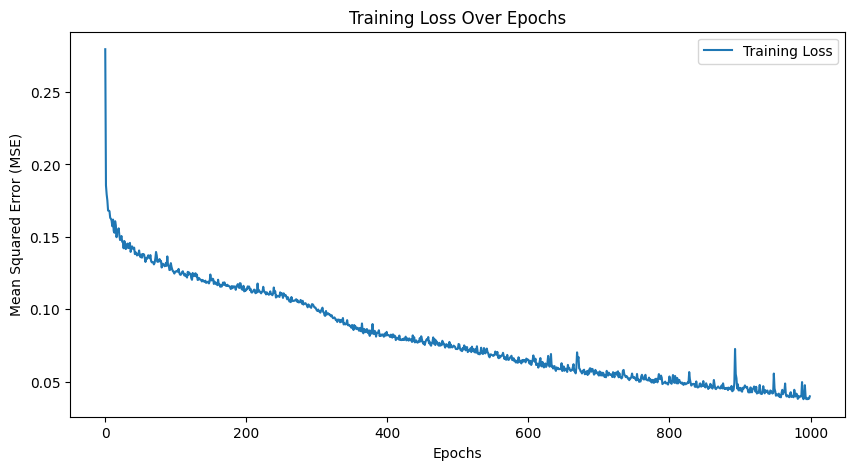

In [ ]:
import matplotlib.pyplot as plt

# Plot Training & Validation Loss
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
#plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Mean Squared Error (MSE)")
plt.title("Training Loss Over Epochs")
plt.legend()
plt.show()

49/49 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step


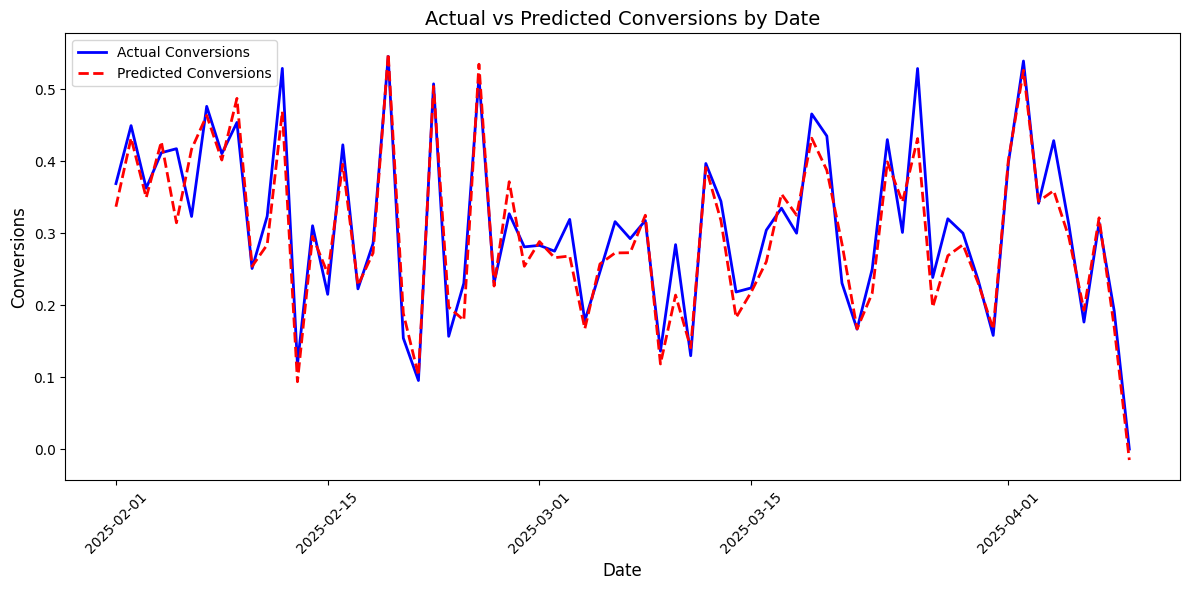

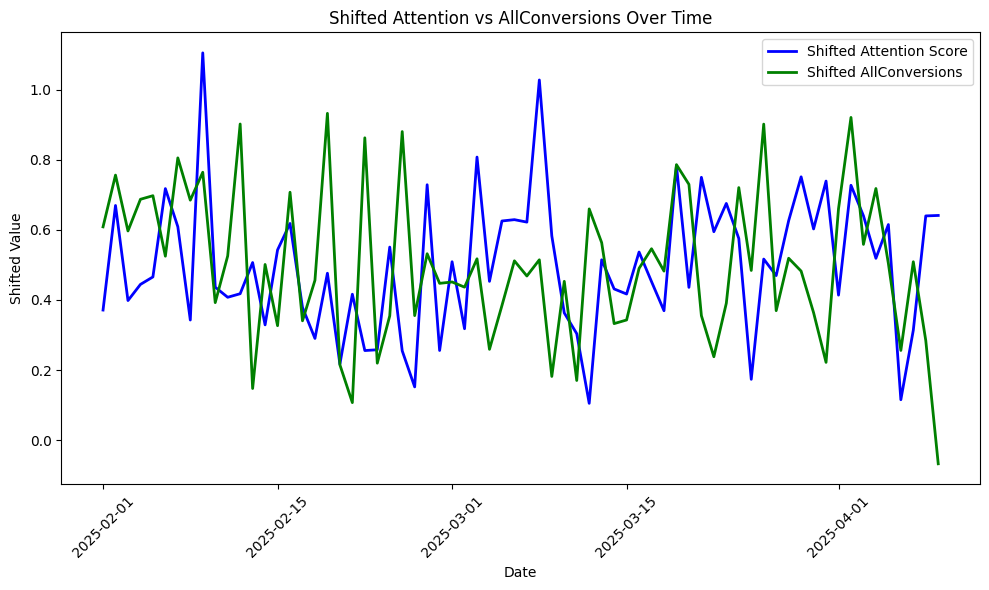

In [ ]:
import matplotlib.pyplot as plt

# Make predictions on the input data
predictions = model.predict([X_search_term, X_numerical])

# Flatten predictions if necessary
predictions = predictions.flatten()

# Add the predictions to the DataFrame for easier manipulation
df['PredictedConversions'] = predictions

# Group by date and calculate the mean actual and predicted conversions
df_grouped_by_date = df.groupby('Date').agg({'AllConversions': 'mean', 'PredictedConversions': 'mean'}).reset_index()

# Plot the actual vs predicted conversions grouped by date
plt.figure(figsize=(12, 6))
plt.plot(df_grouped_by_date['Date'], df_grouped_by_date['AllConversions'], label='Actual Conversions', color='blue', linewidth=2)
plt.plot(df_grouped_by_date['Date'], df_grouped_by_date['PredictedConversions'], label='Predicted Conversions', color='red', linestyle='--', linewidth=2)

# Adding titles and labels
plt.title("Actual vs Predicted Conversions by Date", fontsize=14)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Conversions", fontsize=12)
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

# Compute the average attention score per sample
df['AttentionScore'] = np.mean(attention_scores_values, axis=(1, 2))

# Create a new DataFrame with the average AttentionScore and AllConversions per day
df_grouped = df.groupby('Date').agg({'AttentionScore': 'mean', 'AllConversions': 'mean'}).reset_index()

# Rescale both AttentionScore and AllConversions to [0, 1] using MinMaxScaler
scaler = MinMaxScaler()
df_grouped[['AttentionScore', 'AllConversions']] = scaler.fit_transform(df_grouped[['AttentionScore', 'AllConversions']])

# Compute mean values
mean_attention = df_grouped['AttentionScore'].mean()
mean_conversions = df_grouped['AllConversions'].mean()

# Shift both curves so that their means are at the same level
common_offset = 0.5  # Set the new average level
df_grouped['AttentionScore'] += (common_offset - mean_attention)
df_grouped['AllConversions'] += (common_offset - mean_conversions)

# Plot both AttentionScore and AllConversions over time
plt.figure(figsize=(10, 6))
plt.plot(df_grouped['Date'], df_grouped['AttentionScore'], label='Shifted Attention Score', color='blue', linewidth=2)
plt.plot(df_grouped['Date'], df_grouped['AllConversions'], label='Shifted AllConversions', color='green', linewidth=2)

# Adding titles and labels
plt.title("Shifted Attention vs AllConversions Over Time")
plt.xlabel("Date")
plt.ylabel("Shifted Value")
plt.legend()

# Show plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



Search Term Importance: 12.76%
Numerical Feature Importance: 87.24%


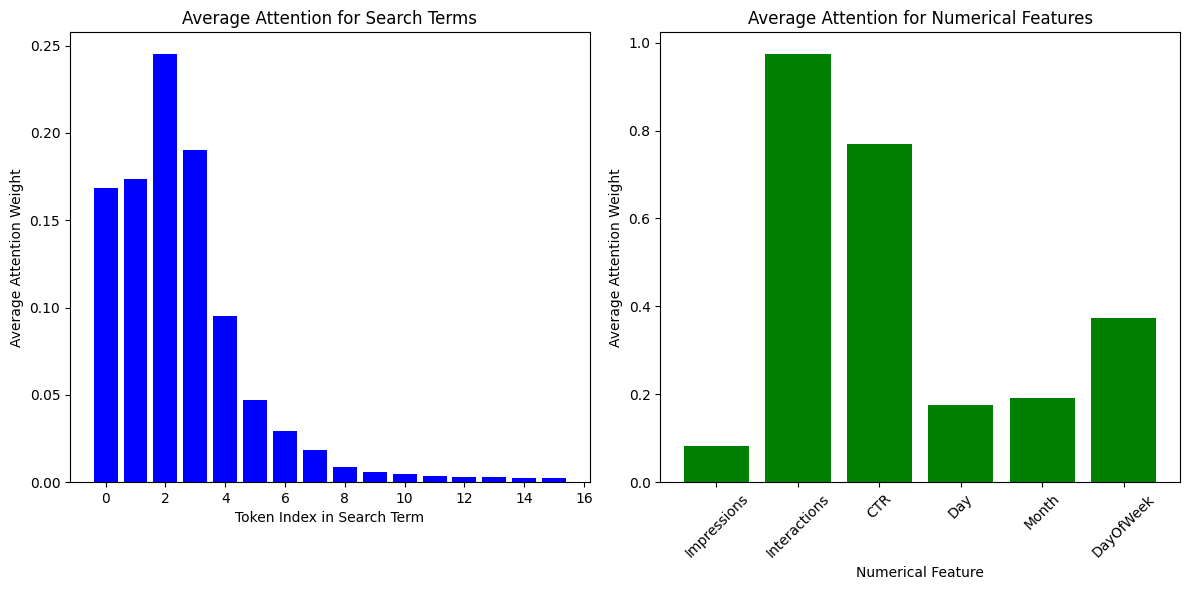

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

avg_attention_search_term = np.mean(attention_scores_values, axis=1).squeeze()
avg_attention_numerical = np.mean(num_attention_scores_values, axis=1).squeeze()

# Sum of attention weights for search terms and numerical features
total_attention_search_term = np.sum(avg_attention_search_term)
total_attention_numerical = np.sum(avg_attention_numerical)

# Compare importance
total_attention = total_attention_search_term + total_attention_numerical
search_term_importance = total_attention_search_term / total_attention
numerical_importance = total_attention_numerical / total_attention

print(f"Search Term Importance: {search_term_importance * 100:.2f}%")
print(f"Numerical Feature Importance: {numerical_importance * 100:.2f}%")

# Flatten the attention scores to make them 1D arrays
avg_attention_search_term = np.mean(attention_scores_values, axis=0).flatten()
avg_attention_numerical = np.mean(num_attention_scores_values, axis=0).flatten()

# Feature names for the numerical features
numerical_feature_names = ['Impressions', 'Interactions', 'CTR', 'Day', 'Month', 'DayOfWeek']

# Plotting the comparison
plt.figure(figsize=(12, 6))

# Plot search term attention
plt.subplot(1, 2, 1)
plt.bar(range(len(avg_attention_search_term)), avg_attention_search_term, color='blue')
plt.title("Average Attention for Search Terms")
plt.xlabel("Token Index in Search Term")
plt.ylabel("Average Attention Weight")

# Plot numerical feature attention
plt.subplot(1, 2, 2)
plt.bar(range(len(avg_attention_numerical)), avg_attention_numerical, color='green')
plt.title("Average Attention for Numerical Features")
plt.xlabel("Numerical Feature")
plt.ylabel("Average Attention Weight")
plt.xticks(range(len(numerical_feature_names)), numerical_feature_names, rotation=45)

plt.tight_layout()
plt.show()



In [ ]:
# 1. Analyze Search Term Attention
# Average attention scores for each word across all samples
avg_attention_weights = np.mean(attention_scores_values, axis=0)  # Average across all samples

# Ensure attention weights match the vocabulary size
# Filter out padding (words with index 0 should not be included)
word_importance = {}
for word, idx in tokenizer.word_index.items():
    if idx > 0 and idx-1 < len(avg_attention_weights):  # Ensure index is within range
        word_importance[word] = avg_attention_weights[idx-1]  # idx-1 due to padding

# Sort words by attention weight
important_words = sorted(word_importance.items(), key=lambda x: x[1])


# 2. Plot Word Importance
top_words = [word for word, _ in important_words[:10]]
top_scores = [score for _, score in important_words[:10]]
# Extract numerical values from the attention score arrays
top_scores = [score[0] for score in top_scores]

# Plot Word Importance
plt.figure(figsize=(10, 6))
plt.barh(top_words, top_scores)
plt.xlabel('Attention Weight')
plt.title('Top 10 Words by Attention Weight')
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from collections import defaultdict

# Make sure SearchTerm is a string
df['SearchTerm'] = df['SearchTerm'].astype(str)

# Get all unique words from search terms
unique_words = set()
df['SearchTerm'].str.lower().str.split().apply(unique_words.update)
unique_words = list(unique_words)

# Dictionary to hold average AllConversions
conversion_dict = defaultdict(float)

# Loop through each word and calculate average AllConversions
for word in unique_words:
    mask = df['SearchTerm'].str.lower().str.contains(fr'\b{word}\b')
    matching_df = df[mask]
    if not matching_df.empty:
        avg_conversion = matching_df['AllConversions'].mean()
        conversion_dict[word] = avg_conversion

# Convert to DataFrame and sort
conversion_df_1word = pd.DataFrame(list(conversion_dict.items()), columns=['Word', 'AvgAllConversions'])
conversion_df_1word = conversion_df_1word.sort_values(by='AvgAllConversions', ascending=False).reset_index(drop=True)

# Show top results
print(conversion_df_1word.head(10))
import matplotlib.pyplot as plt

# Plotting the top 10 one-word expressions by average AllConversions
top_10_1word = conversion_df_1word.head(10)

plt.figure(figsize=(10, 6))
plt.barh(top_10_1word['Word'], top_10_1word['AvgAllConversions'], color='skyblue')
plt.xlabel('Word')
plt.ylabel('Average AllConversions')
plt.title('Top 10 One-Word Expressions by Average AllConversions')
plt.tight_layout()
plt.gca().invert_yaxis()
plt.show()


In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Function to extract bigrams from a sequence of words
def extract_bigrams(text):
    words = text.split()
    return [" ".join([words[i], words[i+1]]) for i in range(len(words)-1)] if len(words) > 1 else []

# Create a dictionary to store the total attention for each bigram
bigram_attention = defaultdict(float)

# Loop through all samples to sum the attention weights for each bigram
for i in range(len(df)):
    # Convert tokenized sequence back to words
    words = tokenizer.sequences_to_texts([search_term_sequences[i]])[0].split()

    # Extract bigrams from words
    bigrams = extract_bigrams(" ".join(words))

    # Get the attention weights for the given sample
    attention_weights_sample = np.squeeze(attention_scores_values[i])

    # Handle padding by considering only the non-padded words
    non_padded_length = len(words)
    attention_weights_sample = attention_weights_sample[:non_padded_length]

    # Update the total attention weight for each bigram
    for j, bigram in enumerate(bigrams):
        if j < len(attention_weights_sample):  # Ensure index safety
            bigram_attention[bigram] += attention_weights_sample[j]

# Sort bigrams by total attention score in descending order
sorted_bigrams = sorted(bigram_attention.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 bigrams with the highest attention scores
top_10_bigrams = sorted_bigrams[:10]
top_10_bigrams, top_10_attention = zip(*top_10_bigrams)

# Plot the top 10 bigrams based on attention
plt.figure(figsize=(10, 6))
plt.barh(top_10_bigrams, top_10_attention)
plt.xlabel('Total Attention Weight')
plt.title('Top 10 Bigrams Yielding High Conversion (Based on Attention Weights)')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()

In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Function to extract bigrams from a sequence of words
def extract_bigrams(text):
    words = text.split()
    return [" ".join([words[i], words[i+1]]) for i in range(len(words)-1)] if len(words) > 1 else []

# Dictionary to store total AllConversions and counts for each bigram
bigram_conversion = defaultdict(float)
bigram_counts = defaultdict(int)

# Loop through all samples to accumulate AllConversions for each bigram
for i in range(len(df)):
    # Convert tokenized sequence back to words
    words = tokenizer.sequences_to_texts([search_term_sequences[i]])[0].split()

    # Extract bigrams
    bigrams = extract_bigrams(" ".join(words))

    # Get the AllConversions value for this sample
    all_conversions = df.iloc[i]["AllConversions"]

    # Accumulate AllConversions for each bigram
    for bigram in bigrams:
        bigram_conversion[bigram] += all_conversions
        bigram_counts[bigram] += 1

# Compute average AllConversions per bigram
bigram_avg_conversion = {
    bigram: bigram_conversion[bigram] / bigram_counts[bigram]
    for bigram in bigram_conversion
}

# Sort bigrams by average AllConversions in descending order
sorted_bigrams = sorted(bigram_avg_conversion.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 bigrams
top_10_bigrams, top_10_avg_conv = zip(*sorted_bigrams[:10])

# Plot the top 10 bigrams based on average AllConversions
plt.figure(figsize=(10, 6))
plt.barh(top_10_bigrams, top_10_avg_conv, color='skyblue')
plt.xlabel('Average AllConversions')
plt.title('Top 10 Bigrams by Average AllConversions')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.tight_layout()
plt.show()


In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Function to extract trigrams from a sequence of words
def extract_trigrams(text):
    words = text.split()
    return [" ".join([words[i], words[i+1], words[i+2]]) for i in range(len(words)-2)] if len(words) > 2 else []

# Create a dictionary to store the total attention for each trigram
trigram_attention = defaultdict(float)

# Loop through all samples to sum the attention weights for each trigram
for i in range(len(df)):
    # Convert tokenized sequence back to words
    words = tokenizer.sequences_to_texts([search_term_sequences[i]])[0].split()

    # Extract trigrams from words
    trigrams = extract_trigrams(" ".join(words))

    # Get the attention weights for the given sample
    attention_weights_sample = np.squeeze(attention_scores_values[i])

    # Handle padding by considering only the non-padded words
    non_padded_length = len(words)
    attention_weights_sample = attention_weights_sample[:non_padded_length]

    # Update the total attention weight for each trigram
    for j, trigram in enumerate(trigrams):
        if j < len(attention_weights_sample):  # Ensure index safety
            trigram_attention[trigram] += attention_weights_sample[j]

# Sort trigrams by total attention score in descending order
sorted_trigrams = sorted(trigram_attention.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 trigrams with the highest attention scores
top_10_trigrams = sorted_trigrams[:10]
top_10_trigrams, top_10_attention = zip(*top_10_trigrams)

# Plot the top 10 trigrams based on attention
plt.figure(figsize=(10, 6))
plt.barh(top_10_trigrams, top_10_attention)
plt.xlabel('Total Attention Weight')
plt.title('Top 10 Trigrams Yielding High Conversion (Based on Attention Weights)')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()


In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Function to extract trigrams from all 3-word combinations
from itertools import combinations

def extract_trigrams(text):
    words = text.split()
    return [" ".join(comb) for comb in combinations(words, 3)] if len(words) >= 3 else []

# Dictionaries to store total AllConversions and counts for each trigram
trigram_conversion = defaultdict(float)
trigram_counts = defaultdict(int)

# Loop through all samples to accumulate AllConversions for each trigram
for i in range(len(df)):
    # Convert tokenized sequence back to words
    words = tokenizer.sequences_to_texts([search_term_sequences[i]])[0].split()

    # Extract trigrams (all 3-word combinations)
    trigrams = extract_trigrams(" ".join(words))

    # Get the AllConversions value for this sample
    all_conversions = df.iloc[i]["AllConversions"]

    # Accumulate AllConversions for each trigram
    for trigram in trigrams:
        trigram_conversion[trigram] += all_conversions
        trigram_counts[trigram] += 1

# Compute average AllConversions per trigram
trigram_avg_conversion = {
    trigram: trigram_conversion[trigram] / trigram_counts[trigram]
    for trigram in trigram_conversion
}

# Sort trigrams by average AllConversions in descending order
sorted_trigrams = sorted(trigram_avg_conversion.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 trigrams
top_10_trigrams, top_10_avg_conv = zip(*sorted_trigrams[:10])

# Plot the top 10 trigrams based on average AllConversions
plt.figure(figsize=(10, 6))
plt.barh(top_10_trigrams, top_10_avg_conv, color='skyblue')
plt.xlabel('Average AllConversions')
plt.title('Top 10 Trigrams by Average AllConversions')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

# Function to extract 4-grams from a sequence of words
def extract_4grams(text):
    words = text.split()
    return [" ".join([words[i], words[i+1], words[i+2], words[i+3]]) for i in range(len(words)-3)] if len(words) > 3 else []

# Create a dictionary to store the total attention for each 4-gram
fourgram_attention = defaultdict(float)

# Loop through all samples to sum the attention weights for each 4-gram
for i in range(len(df)):
    # Convert tokenized sequence back to words
    words = tokenizer.sequences_to_texts([search_term_sequences[i]])[0].split()

    # Extract 4-grams from words
    fourgrams = extract_4grams(" ".join(words))

    # Get the attention weights for the given sample
    attention_weights_sample = np.squeeze(attention_scores_values[i])

    # Handle padding by considering only the non-padded words
    non_padded_length = len(words)
    attention_weights_sample = attention_weights_sample[:non_padded_length]

    # Update the total attention weight for each 4-gram
    for j, fourgram in enumerate(fourgrams):
        if j < len(attention_weights_sample):  # Ensure index safety
            fourgram_attention[fourgram] += attention_weights_sample[j]

# Sort 4-grams by total attention score in descending order
sorted_fourgrams = sorted(fourgram_attention.items(), key=lambda x: x[1], reverse=True)

# Get the top 10 4-grams with the highest attention scores
top_10_fourgrams = sorted_fourgrams[:10]
top_10_fourgrams, top_10_attention = zip(*top_10_fourgrams)

# Plot the top 10 4-grams based on attention
plt.figure(figsize=(10, 6))
plt.barh(top_10_fourgrams, top_10_attention)
plt.xlabel('Total Attention Weight')
plt.title('Top 10 4-Grams Yielding High Conversion (Based on Attention Weights)')
plt.gca().invert_yaxis()  # Invert y-axis for readability
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Compute the average attention score per sample
df['AttentionScore'] = np.mean(attention_scores_values, axis=(1, 2))

# Extract Year-Month for monthly grouping
df['YearMonth'] = df['Date'].dt.to_period('M')

# Group by Year-Month and compute mean attention score
df_monthly = df.groupby('YearMonth')['AttentionScore'].mean().reset_index()

# Convert YearMonth to string for plotting
df_monthly['YearMonth'] = df_monthly['YearMonth'].astype(str)

# Plot the histogram
plt.figure(figsize=(12, 6))
plt.bar(df_monthly['YearMonth'], df_monthly['AttentionScore'], color='blue', alpha=0.7)

# Titles and labels
plt.title("Average Attention Score Per Month")
plt.xlabel("Month")
plt.ylabel("Average Attention Score")
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()


In [ ]:
# Ensure Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract month as a new column
df['Month'] = df['Date'].dt.month

# Group by month and calculate average AllConversions
monthly_avg = df.groupby('Month')['AllConversions'].mean().reset_index()

# Sort by average AllConversions descending
#monthly_avg_sorted = monthly_avg.sort_values(by='AllConversions', ascending=False)

# Display the sorted result
#print(monthly_avg_sorted)

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(monthly_avg['Month'].astype(str), monthly_avg['AllConversions'], color='skyblue')
plt.title('Average AllConversions by Month (Sorted)')
plt.xlabel('Month')
plt.ylabel('Average AllConversions')
plt.grid(axis='y')
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Ensure Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the day of the month
df['Day'] = df['Date'].dt.day

# Compute the average attention score per sample
df['AttentionScore'] = np.mean(attention_scores_values, axis=(1, 2))

# Group by day number to compute the mean attention score
df_day_avg = df.groupby('Day')['AttentionScore'].mean().reset_index()

# Plot the histogram (bar chart)
plt.figure(figsize=(12, 6))
plt.bar(df_day_avg['Day'], df_day_avg['AttentionScore'], color='blue', alpha=0.7)

# Titles and labels
plt.title("Average Attention Score by Day of the Month")
plt.xlabel("Day of the Month")
plt.ylabel("Average Attention Score")
plt.xticks(range(1, 32))  # Ensure all days from 1 to 31 are shown
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show plot
plt.show()



In [ ]:
# Ensure Date column is datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract day of the month
df['Day'] = df['Date'].dt.day

# Group by day and compute average AllConversions
daily_avg = df.groupby('Day')['AllConversions'].mean().reset_index()




import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(daily_avg['Day'].astype(str), daily_avg['AllConversions'], color='skyblue')
plt.title('Average AllConversions by Day of the Month (Sorted)')
plt.xlabel('Day of the Month')
plt.ylabel('Average AllConversions')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
# 1. Extract Day of the Week
# Assuming 'Date' column is in datetime format, if not, you can convert it using pd.to_datetime
df['Date'] = pd.to_datetime(df['Date'])  # Make sure the Date column is in datetime format
df['DayOfWeek'] = df['Date'].dt.dayofweek  # Get the day of the week (0=Monday, 6=Sunday)

# 2. Compute Attention Scores
df['AttentionScore'] = np.mean(attention_scores_values, axis=(1, 2))  # Compute avg attention per sample

# 3. Group by Day of the Week
# You can group by 'DayOfWeek' and compute the average attention score for each day
day_of_week_attention = df.groupby('DayOfWeek')['AttentionScore'].mean()

# Map days of the week to labels for better readability
days_of_week = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_of_week_attention.index = days_of_week

# 4. Plot the Attention Score Over Days of the Week
plt.figure(figsize=(10, 6))
day_of_week_attention.plot(kind='bar')
plt.title("Average Attention Score by Day of the Week")
plt.xlabel("Day of the Week")
plt.ylabel("Average Attention Score")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Ensure the Date column is in datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Extract the day of the week (0 = Monday, 6 = Sunday)
df['DayOfWeek'] = df['Date'].dt.dayofweek

# Optional: Create a mapping to get weekday names
#weekday_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
#df['Weekday'] = df['DayOfWeek'].apply(lambda x: weekday_names[x])

# Group by weekday name and compute the average AllConversions
weekly_avg = df.groupby('DayOfWeek')['AllConversions'].mean().reset_index()

# Ensure weekdays are in correct order
#weekly_avg['DayIndex'] = weekly_avg['Weekday'].apply(lambda x: weekday_names.index(x))

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.bar(weekly_avg['DayOfWeek'], weekly_avg['AllConversions'], color='skyblue')
plt.title('Average AllConversions by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average AllConversions')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Remove negative or NaN values in Interactions
df_filtered = df[df['Interactions'] >= 0].copy()

# Group by the exact number of interactions and compute the average attention score
df_interaction_avg = df_filtered.groupby('Interactions', as_index=False)['AttentionScore'].mean()

# Plot the line (curve) plot
plt.figure(figsize=(12, 6))
plt.plot(df_interaction_avg['Interactions'], df_interaction_avg['AttentionScore'], color='blue', linewidth=2, marker='o', markersize=5)

# Titles and labels
plt.title("Average Attention Score by Number of Interactions", fontsize=14)
plt.xlabel("Number of Interactions", fontsize=12)
plt.ylabel("Average Attention Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()



In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace with your own df)
# df = pd.read_csv('your_data.csv')

# Group by 'Interactions' and calculate the average 'AllConversions'
avg_conversion_by_interactions = df.groupby('Interactions')['AllConversions'].mean().reset_index()

# Sort the data by 'Interactions' for better visualization
avg_conversion_by_interactions = avg_conversion_by_interactions.sort_values(by='Interactions')

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(avg_conversion_by_interactions['Interactions'], avg_conversion_by_interactions['AllConversions'], marker='o', linestyle='-', color='skyblue')

# Add titles and labels
plt.title('Average AllConversions by Interactions')
plt.xlabel('Interactions')
plt.ylabel('Average AllConversions')

# Display the plot
plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Group by the 'Impressions' value and compute the average attention score
df_impressions_avg = df.groupby('Impressions', as_index=False)['AttentionScore'].mean()

# Plot the line (curve) plot
plt.figure(figsize=(12, 6))
plt.plot(df_impressions_avg['Impressions'], df_impressions_avg['AttentionScore'], color='blue', linewidth=2, marker='o', markersize=5)

# Titles and labels
plt.title("Average Attention Score by Impressions", fontsize=14)
plt.xlabel("Impressions", fontsize=12)
plt.ylabel("Average Attention Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace with your own df)
# df = pd.read_csv('your_data.csv')

# Group by 'Interactions' and calculate the average 'AllConversions'
avg_conversion_by_interactions = df.groupby('Impressions')['AllConversions'].mean().reset_index()

# Sort the data by 'Interactions' for better visualization
avg_conversion_by_interactions = avg_conversion_by_interactions.sort_values(by='Impressions')

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(avg_conversion_by_interactions['Impressions'], avg_conversion_by_interactions['AllConversions'], marker='o', linestyle='-', color='skyblue')

# Add titles and labels
plt.title('Average AllConversions by Impressions')
plt.xlabel('Impressions')
plt.ylabel('Average AllConversions')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Remove negative or NaN values in CTR
df_filtered = df[df['CTR'] > 0].copy()

# Group by the CTR value and compute the average attention score
df_ctr_avg = df_filtered.groupby('CTR', as_index=False)['AttentionScore'].mean()

# Plot the line (curve) plot
plt.figure(figsize=(12, 6))
plt.plot(df_ctr_avg['CTR'], df_ctr_avg['AttentionScore'], color='green', linewidth=2, marker='o', markersize=5)

# Titles and labels
plt.title("Average Attention Score by CTR", fontsize=14)
plt.xlabel("CTR (Click-Through Rate)", fontsize=12)
plt.ylabel("Average Attention Score", fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

# Show plot
plt.tight_layout()
plt.show()


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Example data (replace with your own df)
# df = pd.read_csv('your_data.csv')

# Group by 'Interactions' and calculate the average 'AllConversions'
avg_conversion_by_interactions = df.groupby('CTR')['AllConversions'].mean().reset_index()

# Sort the data by 'Interactions' for better visualization
avg_conversion_by_interactions = avg_conversion_by_interactions.sort_values(by='CTR')

# Plot the result
plt.figure(figsize=(10, 6))
plt.plot(avg_conversion_by_interactions['CTR'], avg_conversion_by_interactions['AllConversions'], marker='o', linestyle='-', color='skyblue')

# Add titles and labels
plt.title('Average AllConversions by CTR')
plt.xlabel('CTR')
plt.ylabel('Average AllConversions')

# Display the plot
plt.tight_layout()
plt.show()

In [ ]:
# Define the expression to filter for
expression = "home care"  # Change to your target expression

# Filter rows where the 'SearchTerm' contains the expression (case-insensitive)
filtered_df = df[df['SearchTerm'].str.contains(expression, case=False, na=False)]

# Group by 'SearchTerm' and calculate the average AllConversions
sorted_terms = (
    filtered_df.groupby('SearchTerm')['AllConversions']
    .mean()
    .sort_values(ascending=False)
    .reset_index()
)

# Show the result
print(sorted_terms)


In [ ]:
import pandas as pd

# Example: expression to match (case-insensitive)
expression = "in dubai"

# Filter search terms containing the expression
filtered_df = df[df['SearchTerm'].str.contains(expression, case=True, na=False)]

# Calculate average AllConversions
average_all_conversions = filtered_df['AllConversions'].mean()

print(f"Average AllConversions for search terms containing '{expression}': {average_all_conversions:.2f}")

# Example: expression to match (case-insensitive)
expression = "nanny service"

# Filter search terms containing the expression
filtered_df = df[df['SearchTerm'].str.contains(expression, case=True, na=False)]

# Calculate average AllConversions
average_all_conversions = filtered_df['AllConversions'].mean()

print(f"Average AllConversions for search terms containing '{expression}': {average_all_conversions:.2f}")
# Example: expression to match (case-insensitive)
expression = "home care"

# Filter search terms containing the expression
filtered_df = df[df['SearchTerm'].str.contains(expression, case=True, na=False)]

# Calculate average AllConversions
average_all_conversions = filtered_df['AllConversions'].mean()

print(f"Average AllConversions for search terms containing '{expression}': {average_all_conversions:.2f}")

# Example: expression to match (case-insensitive)
expression = "nanny in"

# Filter search terms containing the expression
filtered_df = df[df['SearchTerm'].str.contains(expression, case=True, na=False)]

# Calculate average AllConversions
average_all_conversions = filtered_df['AllConversions'].mean()

print(f"Average AllConversions for search terms containing '{expression}': {average_all_conversions:.2f}")



